

# Sentinel-2 ESA L2A Example

## Initialise

In [1]:
%matplotlib inline

import datacube
import sys
sys.path.append('/home/jovyan/odc-hub/')
dc = datacube.Datacube(app='s2-example')

## Set up your Datacube Query

In [2]:
query = {}
query['product'] = 's2_esa_sr_granule'  # for this example we will load some data from Sentinel-2
query['output_crs'] = 'EPSG:32760'  # let's output our data in the Fiji projection
#query['group_by'] = 'solar_day'  # datasets can often overlap, we will combine all data that occurs on the same day

## Define your time of interest

In [3]:
# Time does not need to be set, if you want to do a full time search (NOT recommended!)
# You can specifcy a specific day:
# query['time'] = '2011-10-15'
# or can be expressed as a range:
# query['time'] = ('2011-11-14','2011-11-16')
# time can be formatted as either '20111015' or '2011-10-15'
query['time'] = ('2019-1-1', '2019-6-1')

## Define your area of interest

In [4]:
# Similar to to time, a spatial area of interest does not need to be set (NOT recommended!)
# You can specify a specific Sentinel 2 MGRS location using region code:
# query['region_code']='089079'
# alternatively you can create a bounding box, to do this you need three parameters:
#query['x'] = (177.9998, 179.0434)
#query['y'] = (-19.0809, -18.0857)
#query['x'] = (178.2819, 178.6019)
#query['y'] = (-18.2316, -18.0516)
#query['x'] = (177.47773754688 , 177.80732739063)
#query['y']= (-17.284517458341, -17.530336550138)
#query['x'] = (177.2233772277832, 177.33976364135742)
#query['y'] = (-18.034402566877027, -18.119586818424143)

#query['x'] = (177.23196029663086, 177.33169555664062)
#query['y'] = (-18.117792174646194, -18.008773938560065)

#query['x'] = (177.55176544189453, 177.68840789794922)
#query['y'] =  (-18.231307879658033, -18.154660251578434)

query['x'] = (178.3729076385498, 178.43161582946777)
query['y'] = (-18.139734510631563, -18.09813146382932)

#query['crs'] = 'EPSG:3460'

## Load and visualise area of interest quickly

## Load data and mask
For the details on masking Sentinel-2 products, see:
- Level-2A Algorithm Overview at https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm
- section 3 of https://sentinel.esa.int/documents/247904/685211/Sentinel-2-Products-Specification-Document

In [5]:
full_resolution = dc.load(
    resolution = (-30, 30), # this is the 'native' or 'full' resolution of Sentinel-2 data
    measurements=['red','green','blue','scene_classification'], # for this example we will also retrieve the 'scene_classification' band
    **query #use the query we defined above
)

In [6]:
print(full_resolution)

<xarray.Dataset>
Dimensions:               (time: 57, x: 210, y: 156)
Coordinates:
  * time                  (time) datetime64[ns] 2019-01-02T22:30:09 ... 2019-05-29T22:19:49
  * y                     (y) float64 7.998e+06 7.998e+06 ... 7.994e+06
  * x                     (x) float64 6.452e+05 6.453e+05 ... 6.515e+05
Data variables:
    red                   (time, y, x) uint16 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    green                 (time, y, x) uint16 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    blue                  (time, y, x) uint16 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    scene_classification  (time, y, x) uint8 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
Attributes:
    crs:      EPSG:32760


# Plot as cloudy RGB image
full_resolution[['red','green','blue']].to_array().plot.imshow(
    col='time',
    figsize=(10, 10),
    vmin=0,
    vmax=3000
)

# Identify pixels with valid data:
good_quality = (
    (full_resolution.scene_classification != 0) & # mask out NO_DATA
    (full_resolution.scene_classification != 1) & # mask out SATURATED_OR_DEFECTIVE
    (full_resolution.scene_classification != 3) & # mask out CLOUD_SHADOWS
    (full_resolution.scene_classification != 8) & # mask out CLOUD_MEDIUM_PROBABILITY
    (full_resolution.scene_classification != 9) & # mask out CLOUD_HIGH_PROBABILITY
    (full_resolution.scene_classification != 10)  # mask out THIN_CIRRUS
)

In [7]:
from utils_sac.clean_mask import landsat_qa_clean_mask
baseline_clean_mask = landsat_qa_clean_mask(full_resolution, "SENTINEL_2")

In [8]:
# Apply mask
full_resolution_masked = full_resolution.where(baseline_clean_mask)

In [9]:
print(full_resolution_masked.time)

<xarray.DataArray 'time' (time: 57)>
array(['2019-01-02T22:30:09.000000000', '2019-01-04T22:19:31.000000000',
       '2019-01-07T22:30:01.000000000', '2019-01-09T22:19:39.000000000',
       '2019-01-12T22:30:09.000000000', '2019-01-14T22:19:41.000000000',
       '2019-01-17T22:30:11.000000000', '2019-01-19T22:19:39.000000000',
       '2019-01-22T22:30:09.000000000', '2019-01-24T22:19:41.000000000',
       '2019-01-27T22:30:11.000000000', '2019-01-29T22:19:39.000000000',
       '2019-02-01T22:30:09.000000000', '2019-02-03T22:19:41.000000000',
       '2019-02-06T22:30:11.000000000', '2019-02-08T22:19:39.000000000',
       '2019-02-11T22:30:09.000000000', '2019-02-13T22:18:51.000000000',
       '2019-02-16T22:28:51.000000000', '2019-02-18T22:19:39.000000000',
       '2019-02-21T22:30:09.000000000', '2019-02-23T22:19:41.000000000',
       '2019-02-26T22:30:01.000000000', '2019-02-28T22:19:39.000000000',
       '2019-03-03T22:30:09.000000000', '2019-03-05T22:19:31.000000000',
       '2019-0

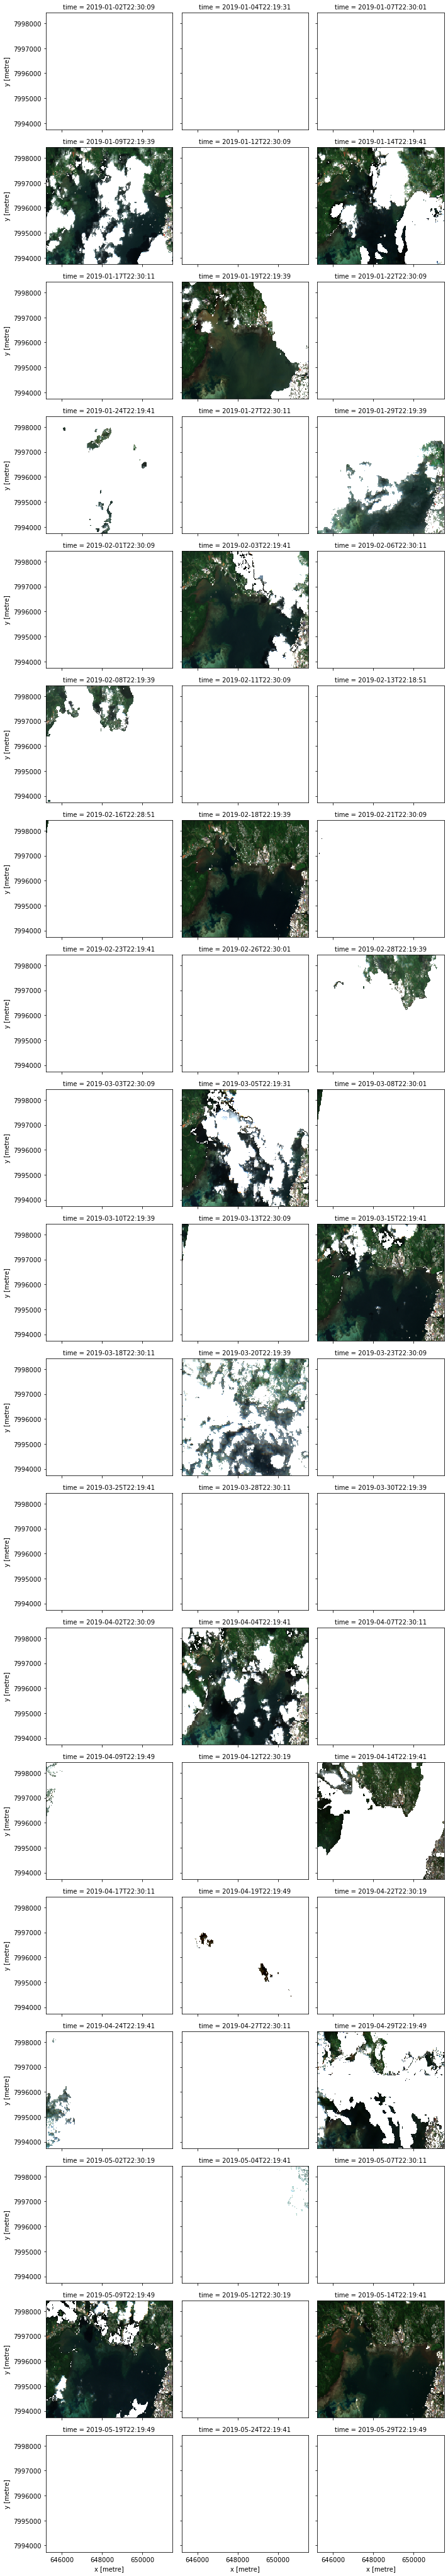

In [10]:
# Plot as cloud free RGB image
full_resolution_masked[['red','green','blue']].to_array().plot.imshow(
    col='time', 
    col_wrap=3,
    vmin=0,
    vmax=3000
)

In [11]:
print('help')

help
